## TODOS

1. How to handle multiple notes at same time-step? (e.g. chords, drumming)
2. How to handle note loudness?
3. How to handle silence?  
4. How to seed different predictions? 
5. Select `key` of song
6. How to handle sections (e.g. verse, chorus, etc.)?
	- Need to do `pattern analysis`

In [1]:
import platform; platform.mac_ver()
# Should be 12.3 or greater, and 'arm64'

('14.5', ('', '', ''), 'arm64')

In [2]:
import matplotlib.pyplot as plt
import torch as torch
import numpy as np
import pypianoroll as pr
# docs: https://hermandong.com/pypianoroll/getting_started.html

In [3]:
import sys, os
sys.path.append(os.path.abspath('/src'))

from src.util.types import PianoState, NoteSample, PianoStateSamples
from src.util.globals import resolution, beats_per_bar, num_pitches, DEVICE
from src.util.convert import (
	convert_states_to_pianoroll,
 	convert_pianoroll_to_piano_states,
	output_piannoroll_to_midi
)
from src.util.plot import plot_pianoroll, plot_piano_states, plot_note_sample_probs, plot_track
from src.models import MusicRNN
from src.models.train import train
from src.models.infer import sample_notes

from src.dataset.load import (
    get_all_npz_files,
    load_multi_track,
    get_track_by_instrument,
)

# Pianoroll Dataset

## Loading Data

In [4]:
files = get_all_npz_files()
print(f'Found {len(files)} total files')

Found 21425 total files


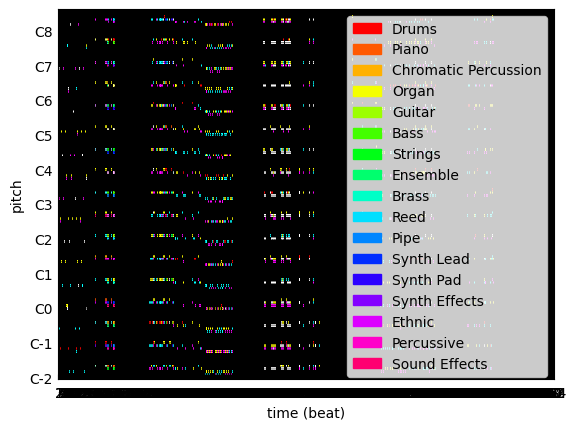

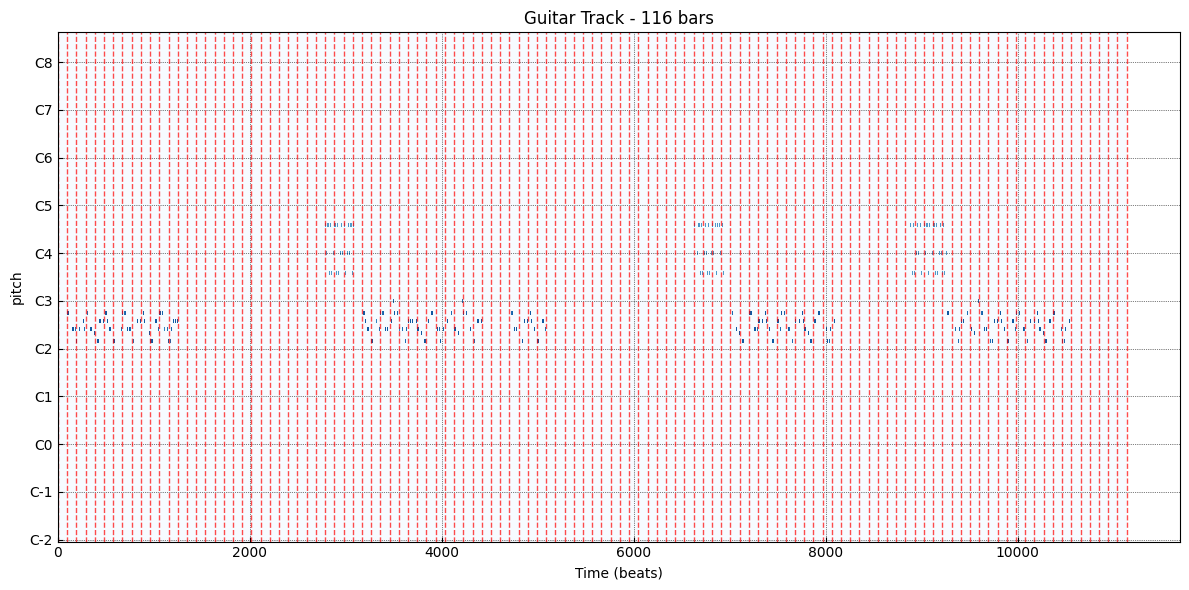

In [5]:
# TESTING
if True:
	desired_instrument = 'Guitar'

	# EXAMPLE: Load a NPZ file into a Multitrack object.
	multi_track = load_multi_track(f'A/A/A/TRAAAGR128F425B14B/b97c529ab9ef783a849b896816001748.npz')
	pr.plot_multitrack(multi_track, axs=None, mode='blended')

	track = get_track_by_instrument(multi_track, desired_instrument)

	if track:
		plot_track(track, desired_instrument)
	else:
		print('No track found')

In [6]:
# Collect piano-roll data for specific instruments
def get_samples(
	desired_instrument = 'Bass',
	max_samples = 100,
) -> list[list[PianoState]]:
	dataset: list[list[PianoState]] = []

	for filepath in files:

		if len(dataset) > max_samples:
			break

		try:
			multi_track = pr.load(filepath)
		except:
			print(f'Error loading file: {filepath}')
			continue

		desired_track = get_track_by_instrument(multi_track, desired_instrument)

		if desired_track:
			# we found it
			desired_pianoroll = desired_track.pianoroll
			dataset.append(
				convert_pianoroll_to_piano_states(desired_pianoroll)
			)

	return dataset


dataset = get_samples('Guitar', 20)


## Create the model

In [11]:
model = MusicRNN(
    hidden_size=128,
    num_pitches=129,  # 0-128 notes (including silence at 0)
    num_layers=2,
    dropout=0.1
)

model = model.to(DEVICE)

print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

Model parameters: 66178


## Testing (toy data)

In [8]:
# Create some simple test sequences
test_seq_1 = torch.Tensor([
	[1, 10],
	[2, 10],
 	[3, 10],
  	[4, 10],
   	[5, 10],
    [4, 10],
    [3, 10],
    [2, 10],
    [1, 10],
	[2, 10],
 	[3, 10],
  	[4, 10],
   	[5, 10],
    [4, 10],
    [3, 10],
    [2, 10],
    [1, 10],
]).float()

test_seq_2 = torch.Tensor([
	[1, 10],
	[2, 10],
 	[3, 10],
  	[4, 10],
   	[5, 10]
]).float()

In [9]:
seq = test_seq_1
start_notes = seq[0]
max_len = 100

# TEST Overfit on 1 sequence
if False:
	train(model, [seq], num_epochs=3000, lr=0.0001)

	# Test sampling a sequence
	piano_state_samples = sample_notes(model, start_notes, max_len)

	plot_piano_states(seq, None, 'Real Sequence')
	plot_piano_states(piano_state_samples.piano_states, None, 'Generated Sequence')
	plot_note_sample_probs(piano_state_samples.note_samples)

## Testing (Real Data)

In [12]:
# for only one seq:
# tensor_dataset = torch.Tensor([dataset[0]]).to(DEVICE)

def round_to_nearest_eighth(ticks: int, resolution: int) -> float:
	"""
	Round a tick duration to the nearest 1/8 note (i.e. 0.5 beats).
	Returns the result in beats.
	"""
	beats = ticks / resolution
	return round(beats * 2) / 2  # 1/8 note = 0.5 beat

trimmed_seqs = []

for i, seq in enumerate(dataset):
	print(f'seq #{i}:')
	print('\tlength = ', len(seq))

	silence_ticks = seq[0][1] if seq[0][0] == 0 else 0

	silence_beats = silence_ticks / resolution

	rounded_beats = round_to_nearest_eighth(silence_ticks, resolution)
	rounded_ticks = int(rounded_beats * resolution)
	start_point_after_first = rounded_ticks % resolution

	print(f'\t# silence beats at start (raw): {silence_beats:.6f}')
	print(f'\t# silence beats at start (rounded to 1/8): {rounded_beats}')
	print(f'\tstart point after first beat: {start_point_after_first}')

	# Trim and add to new set
	start_time = int(rounded_beats*resolution+start_point_after_first)
	print(f'\t=> start time = {start_time}')

	new_seq = seq[start_time:]
	if len(new_seq) == 0:
		print('\tSequence now empty!')
		continue

	trimmed_seqs.append(seq[start_time:])


# Resulting lengths:
print('resulting lengths: ')
for seq in trimmed_seqs:
    print(len(seq))

# for multiple
tensor_dataset = [
	torch.Tensor(seq).to(DEVICE)
	for seq in trimmed_seqs
]

if True:
	losses = train(model, tensor_dataset, num_epochs=1000, lr=0.001)

seq #0:
	length =  600
	# silence beats at start (raw): 7.958333
	# silence beats at start (rounded to 1/8): 8.0
	start point after first beat: 0
	=> start time = 192
seq #1:
	length =  1331
	# silence beats at start (raw): 4.000000
	# silence beats at start (rounded to 1/8): 4.0
	start point after first beat: 0
	=> start time = 96
seq #2:
	length =  578
	# silence beats at start (raw): 8.000000
	# silence beats at start (rounded to 1/8): 8.0
	start point after first beat: 0
	=> start time = 192
seq #3:
	length =  1434
	# silence beats at start (raw): 14.000000
	# silence beats at start (rounded to 1/8): 14.0
	start point after first beat: 0
	=> start time = 336
seq #4:
	length =  174
	# silence beats at start (raw): 4.000000
	# silence beats at start (rounded to 1/8): 4.0
	start point after first beat: 0
	=> start time = 96
seq #5:
	length =  80
	# silence beats at start (raw): 2.500000
	# silence beats at start (rounded to 1/8): 2.5
	start point after first beat: 12
	=> start time = 

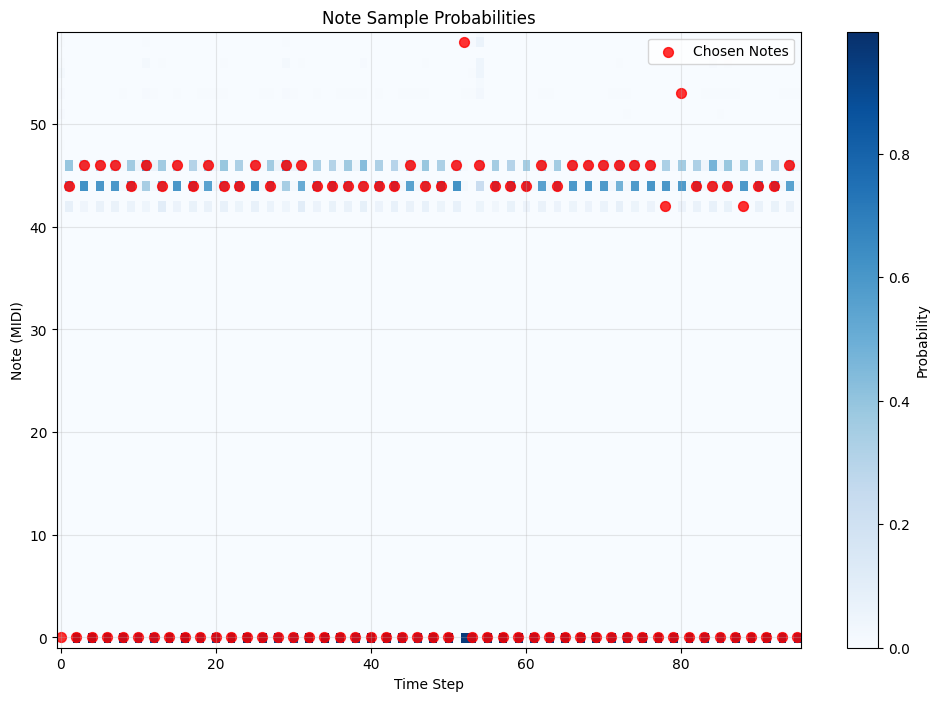

In [44]:
if True:
	predictions = sample_notes(
		model,
		start_event=torch.Tensor(seq[0]),
		length=beats_per_bar*1,
		temperature=0.5
	)

	plot_note_sample_probs(predictions.note_samples)
	output_piannoroll_to_midi(
     	predictions.piano_states,
		instrument='Guitar'
     	'generated_guitar'
    )